# 精炼检测v3--用seg+det模型对所有疑似SWD的object进一步筛选

In [2]:
version = "v1"
run_type = "pose_and_det"  # "pose_and_det" or "cls"

# 需要运行的step列表
steps_to_run = [
    # "run_clean_and_slice_images_on_dirs",           # Step 1 清理坏图并切片大图到640*640小图
    # "process_sliced_images_with_yolo_seg",          # Step 2 使用YOLO-seg模型处理640*640切片图像
    # "combine_sliced_predictions",                   # Step 3 合并seg预测结果，回到原图。 同时切出objects小图
    "run_pose_on_chosen_dirs",                        # Step 4 运行 Pose Estimation（在 cropped_objects 上）
    "run_batch_dot_det",                              # Step 5 运行 det 模型 检测“小黑点”（在 cropped_objects 上）
    "process_swd_matching",                          # Step 6 判定 SWD ⇒ 匹配规则：两翼关键点分别落入两个不同的小黑点框
]

In [3]:
def free_gpu():
    import gc, torch
    gc.collect()                    # 触发 Python 垃圾回收
    torch.cuda.empty_cache()        # 释放未使用的 GPU 缓存到驱动
    torch.cuda.ipc_collect()        # 清理跨进程缓存（偶尔有用）


# Step_0 查看根目录下需要运行的文件夹 
选择含有 raw_data 图片的 *_data 目录

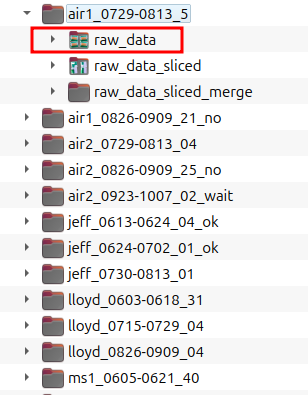


In [4]:
# 选择数据目录的核心代码
from pathlib import Path

def select_data_dirs(root_dir: Path, end_with: str = "_data"):
    # === 1) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("*/*" + end_with))

    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        return []

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 2) 让用户选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs

    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # === 3) 筛选掉没有 raw_data 图片的目录 ===
    chosen_dirs = [
        d for d in chosen_dirs
        if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))
    ]

    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        return []

    return chosen_dirs

In [5]:
root_dir = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = select_data_dirs(root_dir, end_with="_data")
print("最终确认的目录：", chosen_dirs)
if not chosen_dirs:
    raise ValueError("没有选择任何目录，程序终止。")

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
将处理以下 _data 目录：
- 1. /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
最终确认的目录： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data')]


# Step_4 运行 Pose Estimation（在 cropped_objects 上）
读取每张小图（带 uuid_... 命名），输出头(h)、左翼(lp)、右翼(rp) 三关键点

### 输入输出
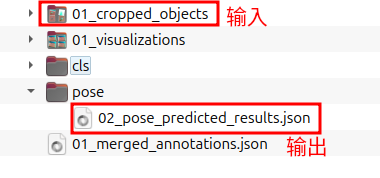

### 效果
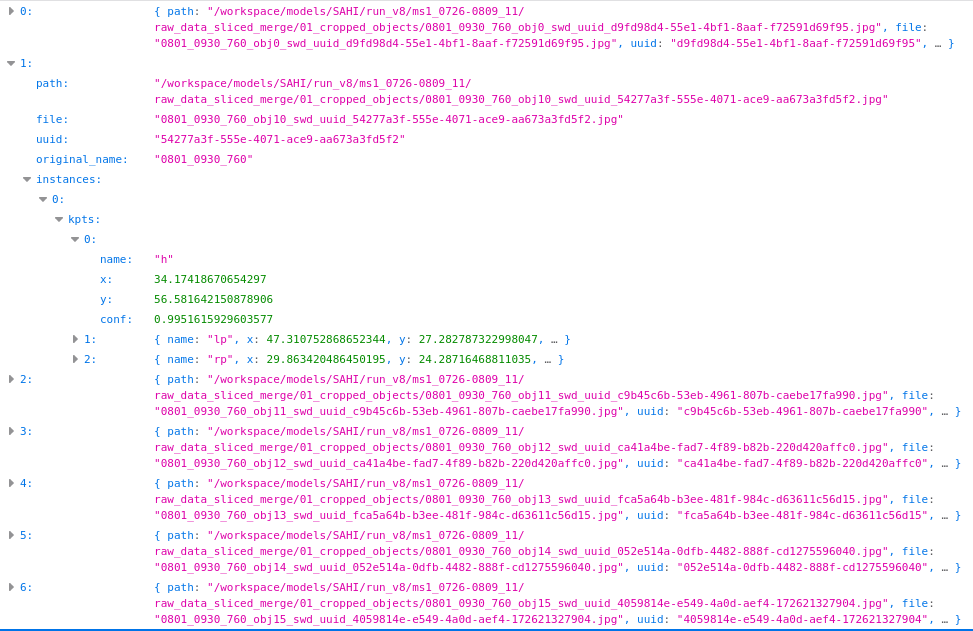

In [97]:
# Step 4: 运行 Pose Estimation
import re, os, json
from pathlib import Path
from typing import List, Dict, Any

from shapely import box
from ultralytics import YOLO

# 文件名解析：..._uuid_<uuid>.jpg
UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)
ORIG_RE = re.compile(r"^(\d+_\d+_\d+)_obj", re.IGNORECASE)

def run_pose_on_dir(
    model_path: str,
    input_dir: Path,
    out_json: Path,
    kpt_names: List[str],
    predict_args: Dict[str, Any]
):
    """
    对单个目录运行姿态估计
    
    Args:
        model_path: 模型路径
        input_dir: 输入图片目录
        out_json: 输出JSON文件路径
        kpt_names: 关键点名称列表
        predict_args: model.predict的参数（必须传入；如果 imgsz=None 则读取模型默认值）
    """
    if not any(input_dir.glob("*.jpg")) and not any(input_dir.glob("*.png")):
        print(f"⚠️ 输入目录无图片：{input_dir}")
        return
    
    print(f"加载姿态模型：{model_path}")
    model = YOLO(model_path)

    # 处理 imgsz=None -> 使用模型默认
    args = dict(predict_args)  # 复制一份
    if "imgsz" in args and args["imgsz"] is None:
        args["imgsz"] = model.overrides.get("imgsz")
        print(f"ℹ️ 使用模型默认 imgsz = {args['imgsz']}")

    results = model.predict(source=str(input_dir), **args)

    out: List[Dict[str, Any]] = []
    for res in results:
        fpath = getattr(res, "path", "")
        fname = os.path.basename(fpath)
        m_uuid = UUID_RE.search(fname)
        uuid_str = m_uuid.group(1) if m_uuid else None
        m_orig = ORIG_RE.match(fname)
        original_name = m_orig.group(1) if m_orig else None

        dets = []
        kpts = getattr(res, "keypoints", None)
        if kpts is not None and kpts.data is not None:
            arr = kpts.data.cpu().numpy()
            conf_arr = getattr(kpts, "conf", None)
            conf_arr = conf_arr.cpu().numpy() if conf_arr is not None else None

            for i in range(arr.shape[0]):
                pts = arr[i]
                item = []
                for ki in range(min(len(kpt_names), pts.shape[0])):
                    x, y = float(pts[ki][0]), float(pts[ki][1])
                    c = float(conf_arr[i][ki]) if (
                        conf_arr is not None and conf_arr.shape == (arr.shape[0], pts.shape[0])
                    ) else None
                    item.append({"name": kpt_names[ki], "x": x, "y": y, "conf": c})
                dets.append({"kpts": item})
        boxes = getattr(res, "boxes", None)
        if boxes is not None and boxes.data is not None:
            arr = boxes.data.cpu().numpy()
            for i in range(arr.shape[0]):
                x1, y1, x2, y2, conf, cls = arr[i]
                item = {
                    "box": {"x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2)},
                    "conf": float(conf),
                    "cls": int(cls)
                }
                if i < len(dets):
                    dets[i]["box"] = item["box"]
                    dets[i]["box_conf"] = item["conf"]
                    dets[i]["box_cls"] = item["cls"]
                else:
                    dets.append(item)

        out.append({
            "path": fpath,
            "file": fname,
            "uuid": uuid_str,
            "original_name": original_name,
            "instances": dets
        })

    out_json.parent.mkdir(parents=True, exist_ok=True)
    with out_json.open("w", encoding="utf-8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    print(f"✅ Pose 结果保存：{out_json}")

def run_pose_on_chosen_dirs(
    chosen_dirs: List[Path],
    model_path: str,
    kpt_names: List[str],
    predict_args: Dict[str, Any]
):
    """
    对选定的目录列表批量运行姿态估计
    
    Args:
        chosen_dirs: 包含图片的目录列表
        model_path: 模型路径
        kpt_names: 关键点名称列表
        predict_args: model.predict的参数（必须传入；imgsz=None 表示自适应模型默认）
    """
    for d in chosen_dirs:
        crops_dir = d.parent / (d.name + "_sliced_merge") / "01_cropped_objects"
        pose_json = d.parent / (d.name + "_sliced_merge") / f"pose_and_det_{version}" / "02_pose_predicted_results.json"
        print(f"\n=== Pose on: {crops_dir} ===")
        run_pose_on_dir(model_path, crops_dir, pose_json, kpt_names, predict_args)


In [98]:
if "run_pose_on_chosen_dirs" in steps_to_run:
    custom_kpt_names = ["h", "lp", "rp"]
    custom_predict_args = {
        "imgsz": None,  # None 表示使用模型默认值
        "conf": 0.88,
        "iou": 0.6,
        "device": 0,
        "verbose": True,
        # "stream": True,
        "batch": 128,
    }

    run_pose_on_chosen_dirs(
        chosen_dirs, 
        model_path="/workspace/models/best_model/yolo11n-pose-best_v2.pt",
        kpt_names=custom_kpt_names,
        predict_args=custom_predict_args
    )
    free_gpu()
else:
    print("Step_4 运行 Pose Estimation（在 cropped_objects 上） 被跳过")


=== Pose on: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects ===
加载姿态模型：/workspace/models/best_model/yolo11n-pose-best_v2.pt
ℹ️ 使用模型默认 imgsz = 640

image 1/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj0_swd_uuid_bd46f5dd-45f2-4344-b820-a836a7f42fa0.jpg: 640x640 (no detections), 0.9ms
image 2/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj10_swd_uuid_27f8568b-b2e2-4fab-b11c-27a64728a5e2.jpg: 640x640 1 swd, 0.9ms
image 3/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj11_swd_uuid_8c31d4bd-6239-423f-8be0-9a2d118b5133.jpg: 640x640 1 swd, 0.9ms
image 4/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj12_swd_uuid_6a653bd2-7a12-400e-aefd-d904e9e175b0.jpg: 640x640 1 swd, 0.9ms
image 5/5900 /workspace/models

# Step_5 运行 det 模型 检测“小黑点”（在 cropped_objects 上）
读取每张小图（带 uuid_... 命名），输出头(h)、左翼(lp)、右翼(rp) 三关键点

### 输入输出
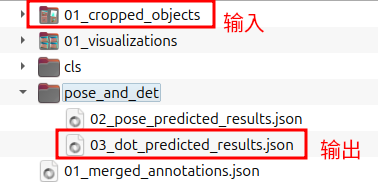

### 效果
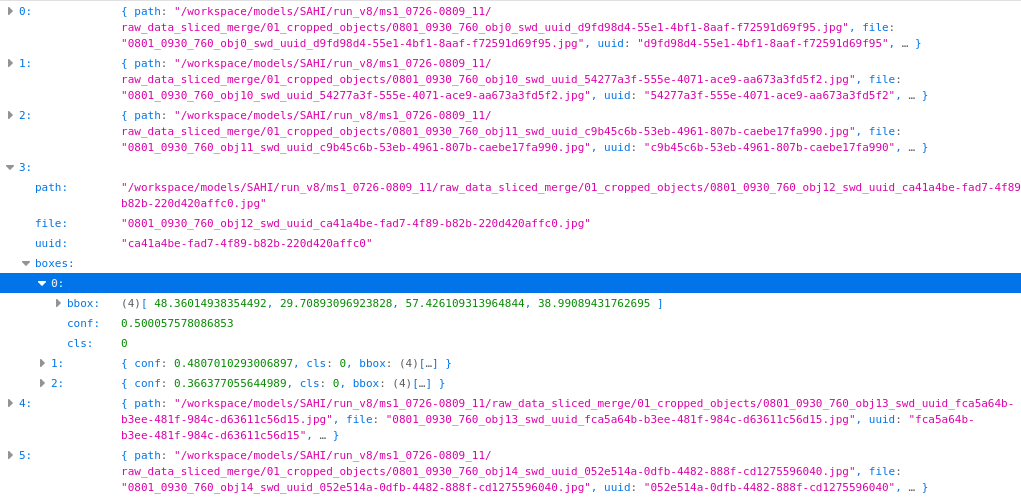

In [5]:
# Step 5: 运行 det 模型 检测“小黑点”
import os, re, json
from pathlib import Path
from typing import Dict, Any, List
from ultralytics import YOLO
import numpy as np

UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

def _to_float_list(x):
    # 把 numpy/tensor 标量安全转成 python float
    return [float(v) for v in x]

def run_dot_det_on_dir(
    model_path: str,
    input_dir: Path,
    out_json: Path,
    custom_predict_args: Dict[str, Any]
):
    if not any(input_dir.glob("*.jpg")) and not any(input_dir.glob("*.png")):
        print(f"⚠️ 输入目录无图片：{input_dir}")
        return

    print(f"加载小黑点检测模型：{model_path}")
    model = YOLO(model_path)

    if custom_predict_args['imgsz'] is None:
        custom_predict_args['imgsz'] = model.overrides.get("imgsz")
        print(f"ℹ️ 使用模型默认 imgsz = {custom_predict_args['imgsz']}")

    # 必须传 custom_predict_args
    results = model.predict(**custom_predict_args, source=str(input_dir))

    out: List[Dict[str, Any]] = []
    for res in results:
        fpath = getattr(res, "path", "")
        fname = os.path.basename(fpath)
        m_uuid = UUID_RE.search(fname)
        uuid_str = m_uuid.group(1) if m_uuid else None

        det_list = []
        boxes = getattr(res, "boxes", None)
        if boxes is not None:
            xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes, "xyxy") else None
            confs = boxes.conf.cpu().numpy() if hasattr(boxes, "conf") and boxes.conf is not None else None
            clses = boxes.cls.cpu().numpy() if hasattr(boxes, "cls") and boxes.cls is not None else None

            if xyxy is not None:
                n = xyxy.shape[0]
                for i in range(n):
                    x1, y1, x2, y2 = _to_float_list(xyxy[i].tolist())
                    conf_score = float(confs[i]) if confs is not None and i < len(confs) else None
                    cls_id = int(clses[i]) if clses is not None and i < len(clses) else 0
                    det_list.append({
                        "bbox": [x1, y1, x2, y2],
                        "conf": conf_score,
                        "cls": cls_id
                    })

        out.append({
            "path": fpath,
            "file": fname,
            "uuid": uuid_str,
            "boxes": det_list
        })

    out_json.parent.mkdir(parents=True, exist_ok=True)
    with out_json.open("w", encoding="utf-8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    print(f"✅ 小黑点检测结果保存：{out_json}")

def run_batch_dot_det(
    chosen_dirs: List[Path],
    dot_model: str,
    custom_predict_args: Dict[str, Any]
):
    """批处理入口：遍历 chosen_dirs，运行小黑点检测；predict 参数必须通过 custom_predict_args 提供"""
    for d in chosen_dirs:
        crops_dir = d.parent / (d.name + "_sliced_merge") / "01_cropped_objects"
        dot_json  = d.parent / (d.name + "_sliced_merge") / f"pose_and_det_{version}" / "03_dot_predicted_results.json"
        print(f"\n=== Dot-Det on: {crops_dir} ===")
        run_dot_det_on_dir(dot_model, crops_dir, dot_json, custom_predict_args=custom_predict_args)


In [14]:
if "run_batch_dot_det" in steps_to_run:
    dot_det_model_path = "/workspace/models/best_model/yolo11n-det-best_v1.pt"
    custom_predict_args = {
        "imgsz": None,  # None 则使用模型默认值
        "conf": 0.1,
        "iou": 0.5,
        "device": 0,
        "verbose": True,
        # "stream": True,
        "batch": 128
    }
    run_batch_dot_det(chosen_dirs, dot_model=dot_det_model_path, custom_predict_args=custom_predict_args)

    free_gpu()
else:
    print("Step_5 运行 det 模型 检测“小黑点”（在 cropped_objects 上） 被跳过")



=== Dot-Det on: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects ===
加载小黑点检测模型：/workspace/models/best_model/yolo11n-det-best_v1.pt
ℹ️ 使用模型默认 imgsz = 640
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.8.0+cu128 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 0
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


# Step_6 判定 SWD ⇒ 匹配规则：两翼关键点分别落入两个不同的小黑点框

### 输入
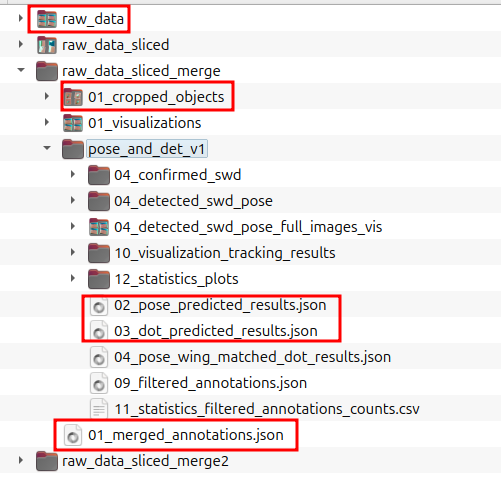

### 输出
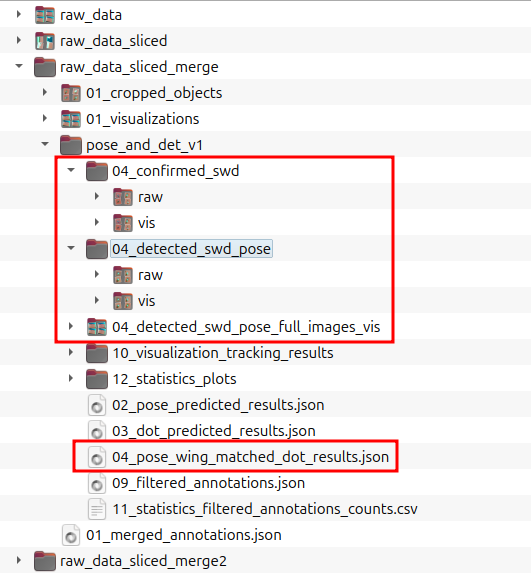


### 效果
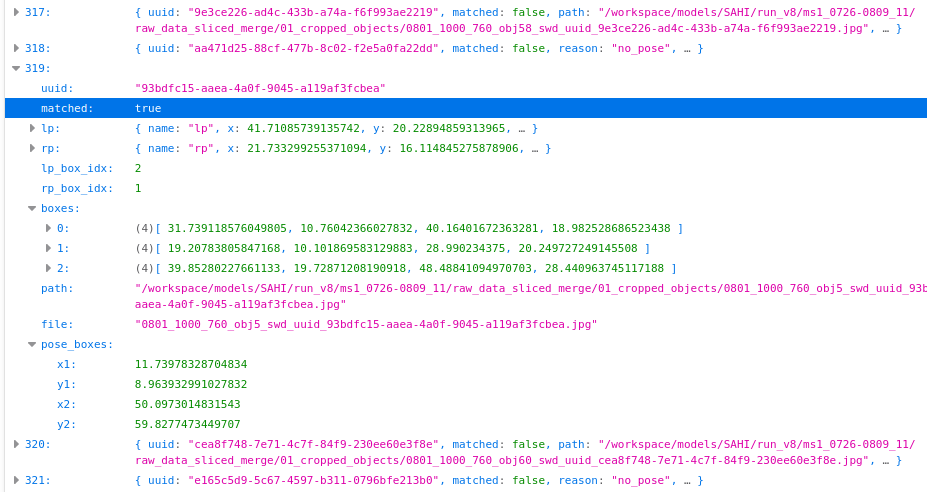
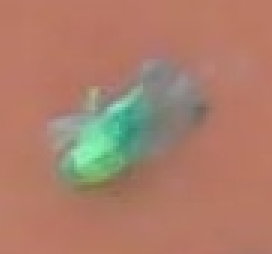
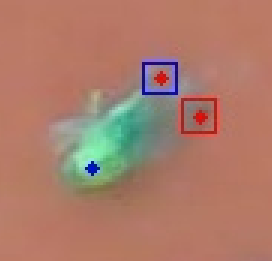

In [26]:
# Step 6: 判定 SWD ⇒ 匹配规则：两翼关键点分别落入两个不同的小黑点框

"""
改进点：
1) 与当初裁剪一致的公式（含 round 和 margin）从 polygon points 反推裁剪块左上角 (ox,oy)，确保坐标对齐。
2) 原图可视化改为“按原图批量渲染”：同一原图只读一次、画完一次、写一次，显著降低 I/O。
3) uuid 标注在 lp/rp 几何中心右上角 30px，带描边，不挡主体。
4) 支持 03_dot_predicted_results.json 的 box 置信度筛选（use_box_conf / box_conf_thr）。
5) 阈值联动可视化：KPT 低于阈值灰色空心；BOX 低于阈值仍显示为灰色细框，达标框彩色并标 conf。
6) 仅绘制 matched 元素（only_draw_matched）：只画命中的两只小黑点框 + lp/rp 两个关键点，提升可读性。

输出目录：
- 小图可视化：.../pose_and_det_{version}/04_detected_swd_pose/vis
- 小图原图：.../pose_and_det_{version}/04_detected_swd_pose/raw
- 原图可视化：.../pose_and_det_{version}/04_detected_swd_pose_full_images_vis
"""

import os, re, shutil
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import cv2
import numpy as np

# ---------- orjson 加速 ----------
import orjson as _fastjson
def _loads(b: bytes): return _fastjson.loads(b)
def _dumps(obj): return _fastjson.dumps(obj, option=_fastjson.OPT_INDENT_2)

UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

# ---------- I/O ----------
def load_json(path: Path):
    with path.open("rb") as f:
        data = f.read()
    return _loads(data)

def save_json(obj: Any, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("wb") as f:
        f.write(_dumps(obj))

# ---------- 点落框 ----------
def hits_for_point(pt: Tuple[float, float], boxes: np.ndarray) -> np.ndarray:
    if boxes.size == 0:
        return np.empty((0,), dtype=np.int32)
    x, y = pt
    cond = (x >= boxes[:, 0]) & (x <= boxes[:, 2]) & (y >= boxes[:, 1]) & (y <= boxes[:, 3])
    return np.flatnonzero(cond).astype(np.int32, copy=False)

def find_kpt(items: List[Dict[str, Any]], name: str) -> Optional[Dict[str, Any]]:
    for it in items:
        if it.get("name") == name:
            return it
    return None

def kpt_ok(k: Optional[Dict[str, Any]], use_point_conf: bool, thr: float) -> bool:
    if not k:
        return False
    if use_point_conf:
        conf = k.get("conf")
        if conf is not None:
            try:
                return float(conf) >= thr
            except Exception:
                return False
    return True

def match_one(uuid_: str,
              pose_items: List[Dict[str, Any]],
              dot_boxes_np: np.ndarray,
              require_different_boxes: bool = True,
              use_point_conf: bool = True,
              kpt_conf_thr: float = 0.15) -> Dict[str, Any]:
    lp = find_kpt(pose_items, "lp")
    rp = find_kpt(pose_items, "rp")

    lp_ok = kpt_ok(lp, use_point_conf, kpt_conf_thr)
    rp_ok = kpt_ok(rp, use_point_conf, kpt_conf_thr)

    matched = False
    lp_in_idx = None
    rp_in_idx = None

    if lp_ok and rp_ok and dot_boxes_np.size:
        lp_hits = hits_for_point((lp["x"], lp["y"]), dot_boxes_np)
        rp_hits = hits_for_point((rp["x"], rp["y"]), dot_boxes_np)

        if lp_hits.size and rp_hits.size:
            if require_different_boxes:
                rp_set = set(int(i) for i in rp_hits.tolist())
                for i in lp_hits.tolist():
                    if i in rp_set:
                        for j in rp_hits.tolist():
                            if j != i:
                                lp_in_idx, rp_in_idx = i, j
                                matched = True
                                break
                        if matched:
                            break
                    else:
                        lp_in_idx, rp_in_idx = i, int(rp_hits[0])
                        matched = True
                        break
                if not matched and lp_hits.size > 1 and rp_hits.size > 1:
                    i = int(lp_hits[0]); j = int(rp_hits[1] if rp_hits[0] == i else rp_hits[0])
                    if i != j:
                        lp_in_idx, rp_in_idx = i, j
                        matched = True
            else:
                matched = True
                lp_in_idx = int(lp_hits[0])
                rp_in_idx = int(rp_hits[0])

    return {
        "uuid": uuid_,
        "matched": matched,
        "lp": lp,
        "rp": rp,
        "lp_box_idx": lp_in_idx,
        "rp_box_idx": rp_in_idx,
    }

# ---------- 可视化辅助：阈值样式、图例 ----------
def _draw_kpts_with_threshold(vis, pose_items, use_point_conf: bool, kpt_conf_thr: float, ox: int = 0, oy: int = 0):
    """
    达标: 实心小圆(原配色); 未达标: 灰色空心细圈。
    """
    for k in pose_items:
        if not k: 
            continue
        name = k.get("name","?")
        x, y = int(float(k["x"]) + ox), int(float(k["y"]) + oy)
        ok = True
        if use_point_conf:
            conf = k.get("conf", None)
            try:
                ok = (conf is not None) and (float(conf) >= float(kpt_conf_thr))
            except Exception:
                ok = False
        if ok:
            color = (255, 0, 0) if name == "h" else (0, 0, 255)
            cv2.circle(vis, (x, y), 2, color, -1)
        else:
            cv2.circle(vis, (x, y), 2, (180,180,180), 1)

def _draw_boxes_with_conf(vis, kept_np, kept_conf, drop_np=None, drop_conf=None, lp_idx=None, rp_idx=None):
    """
    kept：按命中配色；drop：灰色细框。
    左上角标出 conf（四舍五入到两位），drop 的 conf 也会标（灰色）。
    """
    font = cv2.FONT_HERSHEY_SIMPLEX

    # 底层：drop
    if isinstance(drop_np, np.ndarray) and drop_np.size:
        for i in range(drop_np.shape[0]):
            x1, y1, x2, y2 = map(int, drop_np[i])
            cv2.rectangle(vis, (x1, y1), (x2, y2), (170,170,170), 1)
            if isinstance(drop_conf, np.ndarray) and i < drop_conf.shape[0]:
                c = drop_conf[i]
                if not np.isnan(c):
                    cv2.putText(vis, f"{c:.2f}", (x1, max(22,y1+22)), font, 0.3, (60,60,60), 1, cv2.LINE_AA)

    # 上层：kept
    if isinstance(kept_np, np.ndarray) and kept_np.size:
        for i in range(kept_np.shape[0]):
            x1, y1, x2, y2 = map(int, kept_np[i])
            lp_hit = (lp_idx == i)
            rp_hit = (rp_idx == i)
            if lp_hit and rp_hit:   color = (255, 0, 255)
            elif lp_hit:            color = (0, 0, 255)
            elif rp_hit:            color = (255, 0, 0)
            else:                   color = (0, 255, 0)
            cv2.rectangle(vis, (x1, y1), (x2, y2), color, 1)

            if isinstance(kept_conf, np.ndarray) and i < kept_conf.shape[0]:
                c = kept_conf[i]
                if not np.isnan(c):
                    cv2.putText(vis, f"{c:.2f}", (x1, max(22,y1+22)), font, 0.3, color, 1, cv2.LINE_AA)

def _draw_legend_and_thresholds(vis, use_point_conf, kpt_conf_thr, use_box_conf, box_conf_thr, only_draw_matched=False):
    """
    右上角图例 + 阈值信息水印
    """
    H, W = vis.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    x0, y0 = max(0, W - 320), 10
    panel_w, panel_h = 210, 85 if not only_draw_matched else 105
    overlay = vis.copy()
    cv2.rectangle(overlay, (x0, y0), (x0+panel_w, y0+panel_h), (0,0,0), -1)
    cv2.addWeighted(overlay, 0.25, vis, 0.75, 0, vis)

    lines = [
        f"KPT thr: {'ON' if use_point_conf else 'OFF'} {kpt_conf_thr if use_point_conf else ''}",
        f"BOX thr: {'ON' if use_box_conf   else 'OFF'} {box_conf_thr if use_box_conf else ''}",
        "Boxes: kept=color, drop=gray",
        "KPT: ok=solid, low=gray hollow",
    ]
    if only_draw_matched:
        lines.append("Render: only matched")

    for i, t in enumerate(lines):
        yy = y0 + 18 + 18*i
        cv2.putText(vis, t, (x0+8, yy), font, 0.5, (0,0,0), 3, cv2.LINE_AA)
        cv2.putText(vis, t, (x0+8, yy), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ---------- 读取原图尺寸（带缓存） ----------
def _get_image_size(raw_data_dir: Path, orig_name: str, _cache: Dict[str, Tuple[int,int]]) -> Optional[Tuple[int,int]]:
    if orig_name in _cache:
        return _cache[orig_name]
    for ext in (".jpg", ".jpeg", ".png", ".JPG", ".PNG"):
        p = raw_data_dir / f"{orig_name}{ext}"
        if p.exists():
            img = cv2.imread(str(p))
            if img is not None:
                h, w = img.shape[:2]
                _cache[orig_name] = (w, h)
                return (w, h)
    return None

# ---------- 反推裁剪左上角（与当初裁剪一致：center/side_length/round/margin） ----------
def _left_top_from_points(points: List[List[float]], img_w: int, img_h: int, margin: int) -> Tuple[int, int]:
    pts = np.asarray(points, dtype=np.float32)
    xs = pts[:, 0]; ys = pts[:, 1]
    min_x, max_x = float(xs.min()), float(xs.max())
    min_y, max_y = float(ys.min()), float(ys.max())
    bbox_w = max_x - min_x
    bbox_h = max_y - min_y
    side = max(bbox_w, bbox_h)
    cx = 0.5 * (min_x + max_x)
    cy = 0.5 * (min_y + max_y)
    left  = int(round(cx - 0.5 * side)) - margin
    top   = int(round(cy - 0.5 * side)) - margin
    left = max(0, left)
    top  = max(0, top)
    return left, top

# === 从 merged_annotations 构建 uuid -> (orig_name, ox, oy) 映射（优先 points 精确复现裁剪） ===
def _build_uuid_to_fullinfo(merged_json_path: Path, raw_data_dir: Path, crop_margin_px: int) -> Dict[str, Dict[str, Any]]:
    """
    返回:
      uuid -> {
        'orig_name': str,
        'ox': int, 'oy': int,   # 当年实际裁剪左上角（含 margin 与 round，且做过边界裁剪）
        '_src': str,
      }
    """
    if not merged_json_path.exists():
        return {}

    data = load_json(merged_json_path)
    umap: Dict[str, Dict[str, Any]] = {}
    items = data.items() if isinstance(data, dict) else []
    size_cache: Dict[str, Tuple[int,int]] = {}

    def _from_xy(d: Dict[str, Any], xk: str, yk: str):
        if xk in d and yk in d:
            try:
                return int(round(float(d[xk]))), int(round(float(d[yk])))
            except Exception:
                return None
        return None

    def _from_xywh(d: Dict[str, Any], key: str):
        v = d.get(key)
        if isinstance(v, (list, tuple)) and len(v) >= 4:
            try:
                x, y = float(v[0]), float(v[1])
                return int(round(x)), int(round(y))
            except Exception:
                return None
        return None

    for orig_name, anns in items:
        if not isinstance(anns, list):
            continue
        sz = _get_image_size(raw_data_dir, str(orig_name), size_cache)
        for ann in anns:
            uuid_ = ann.get("uuid")
            if not uuid_:
                continue

            got_xy = None
            for xk, yk in [("crop_x","crop_y"), ("tile_x","tile_y"), ("patch_x","patch_y"), ("left","top")]:
                got_xy = _from_xy(ann, xk, yk)
                if got_xy:
                    umap[uuid_] = {"orig_name": str(orig_name), "ox": got_xy[0], "oy": got_xy[1], "_src": f"{xk}_{yk}"}
                    break
            if got_xy:
                continue

            got_xywh = None
            for key in ["crop_xywh", "tile_xywh", "patch_xywh"]:
                got_xywh = _from_xywh(ann, key)
                if got_xywh:
                    umap[uuid_] = {"orig_name": str(orig_name), "ox": got_xywh[0], "oy": got_xywh[1], "_src": key}
                    break
            if got_xywh:
                continue

            pts = ann.get("points")
            if isinstance(pts, (list, tuple)) and pts and sz is not None:
                img_w, img_h = sz[0], sz[1]
                left, top = _left_top_from_points(pts, img_w, img_h, crop_margin_px)
                umap[uuid_] = {"orig_name": str(orig_name), "ox": left, "oy": top, "_src": "points_reconstruct"}
                continue

            bb = ann.get("bbox") or ann.get("box")
            if isinstance(bb, (list, tuple)) and len(bb) == 4:
                x1, y1, x2, y2 = bb
                umap[uuid_] = {"orig_name": str(orig_name), "ox": int(round(float(x1))), "oy": int(round(float(y1))), "_src": "bbox_fallback"}

    return umap

# ---------- 小图可视化（支持阈值联动、仅绘制 matched） ----------
def visualize_match(img_path: Path,
                    pose_items: List[Dict[str, Any]],
                    kept_np: np.ndarray,
                    kept_conf: np.ndarray,
                    drop_np: np.ndarray,
                    drop_conf: np.ndarray,
                    match_info: Dict[str, Any],
                    out_path: Path,
                    use_point_conf: bool,
                    kpt_conf_thr: float,
                    use_box_conf: bool,
                    box_conf_thr: float,
                    only_draw_matched: bool):
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        return
    vis = img.copy()

    lp_idx = match_info.get("lp_box_idx")
    rp_idx = match_info.get("rp_box_idx")

    # 准备仅绘制 matched 的元素？
    if only_draw_matched:
        keep_idx_old = [i for i in [lp_idx, rp_idx] if isinstance(i, int)]
        keep_idx_old = sorted(set(keep_idx_old))
        if keep_idx_old:
            old2new = {old: new for new, old in enumerate(keep_idx_old)}
            kept_np_draw = kept_np[keep_idx_old] if kept_np.size else np.empty((0,4), np.int32)
            kept_conf_draw = kept_conf[keep_idx_old] if kept_conf.size else np.empty((0,), np.float32)
            drop_np_draw = np.empty((0,4), np.int32)
            drop_conf_draw = np.empty((0,), np.float32)
            lp_idx_draw = old2new.get(lp_idx, None)
            rp_idx_draw = old2new.get(rp_idx, None)
        else:
            kept_np_draw = np.empty((0,4), np.int32)
            kept_conf_draw = np.empty((0,), np.float32)
            drop_np_draw = np.empty((0,4), np.int32)
            drop_conf_draw = np.empty((0,), np.float32)
            lp_idx_draw = None
            rp_idx_draw = None

        # 关键点仅保留 lp / rp
        kpts_for_draw = []
        for nm in ("lp", "rp"):
            k = match_info.get(nm)
            if isinstance(k, dict):
                kpts_for_draw.append(k)
    else:
        kept_np_draw = kept_np
        kept_conf_draw = kept_conf
        drop_np_draw = drop_np
        drop_conf_draw = drop_conf
        lp_idx_draw = lp_idx
        rp_idx_draw = rp_idx
        kpts_for_draw = pose_items

    # 画框（drop→灰，kept→彩色+conf）
    _draw_boxes_with_conf(vis, kept_np_draw, kept_conf_draw, drop_np_draw, drop_conf_draw, lp_idx_draw, rp_idx_draw)
    # 画关键点（阈值样式）
    _draw_kpts_with_threshold(vis, kpts_for_draw, use_point_conf, kpt_conf_thr, 0, 0)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), vis)

# === NEW: 批量渲染同一原图的所有叠绘任务，只读写一次（支持阈值联动 & 仅绘制 matched） ===
def _render_full_images_batch(
    raw_data_dir: Path,
    out_full_dir: Path,
    tasks_by_image: Dict[str, List[Dict[str, Any]]],
    jpeg_quality: int = 85,
    use_point_conf: bool = True,
    kpt_conf_thr: float = 0.15,
    use_box_conf: bool = True,
    box_conf_thr: float = 0.45,
    only_draw_matched: bool = False,
):
    out_full_dir.mkdir(parents=True, exist_ok=True)

    for orig_name, items in tasks_by_image.items():
        # 读图（若已存在增量文件，则在其上继续画；否则读原图）
        img_path = None
        for ext in (".jpg", ".jpeg", ".png", ".JPG", ".PNG"):
            p = raw_data_dir / f"{orig_name}{ext}"
            if p.exists():
                img_path = p
                break
        if img_path is None:
            continue

        out_img_path = out_full_dir / f"{orig_name}_full_vis.jpg"
        vis = cv2.imread(str(out_img_path), cv2.IMREAD_COLOR) \
              if out_img_path.exists() else cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if vis is None:
            continue

        H, W = vis.shape[:2]

        # 批量绘制
        for it in items:
            ox, oy = it["ox"], it["oy"]
            kept_np = it["boxes_np"]
            kept_conf = it.get("boxes_conf", np.empty((0,), np.float32))
            drop_np = it.get("drop_np", np.empty((0,4), np.float32))
            drop_conf = it.get("drop_conf", np.empty((0,), np.float32))
            lp_idx, rp_idx = it["lp_idx"], it["rp_idx"]
            pose_items = it["pose_items"]
            uuid_text = it["uuid_text"]

            # 偏移到原图坐标
            if isinstance(kept_np, np.ndarray):
                offs = np.array([ox, oy, ox, oy], dtype=np.float32)
                k_np = (kept_np + offs).astype(np.int32, copy=False)
            else:
                k_np = np.empty((0,4), np.int32)

            if isinstance(drop_np, np.ndarray):
                offs = np.array([ox, oy, ox, oy], dtype=np.float32)
                d_np = (drop_np + offs).astype(np.int32, copy=False)
            else:
                d_np = np.empty((0,4), np.int32)

            # 仅绘制 matched？
            if only_draw_matched:
                keep_idx_old = [i for i in [lp_idx, rp_idx] if isinstance(i, int)]
                keep_idx_old = sorted(set(keep_idx_old))
                if keep_idx_old:
                    old2new = {old: new for new, old in enumerate(keep_idx_old)}
                    k_np_draw = k_np[keep_idx_old] if k_np.size else np.empty((0,4), np.int32)
                    kept_conf_draw = kept_conf[keep_idx_old] if kept_conf.size else np.empty((0,), np.float32)
                    d_np_draw = np.empty((0,4), np.int32)
                    drop_conf_draw = np.empty((0,), np.float32)
                    lp_idx_draw = old2new.get(lp_idx, None)
                    rp_idx_draw = old2new.get(rp_idx, None)
                else:
                    k_np_draw = np.empty((0,4), np.int32)
                    kept_conf_draw = np.empty((0,), np.float32)
                    d_np_draw = np.empty((0,4), np.int32)
                    drop_conf_draw = np.empty((0,), np.float32)
                    lp_idx_draw = None
                    rp_idx_draw = None

                # 关键点仅保留 lp/rp，且已是原图坐标
                kpts_for_draw = []
                for nm in ("lp","rp"):
                    src = None
                    for kk in pose_items:
                        if kk and kk.get("name")==nm:
                            src = kk
                            break
                    if src:
                        kpts_for_draw.append({"name": nm,
                                              "x": float(src["x"]) + ox,
                                              "y": float(src["y"]) + oy,
                                              "conf": src.get("conf")})
                kpt_ox, kpt_oy = 0, 0
            else:
                k_np_draw = k_np
                kept_conf_draw = kept_conf
                d_np_draw = d_np
                drop_conf_draw = drop_conf
                lp_idx_draw = lp_idx
                rp_idx_draw = rp_idx
                kpts_for_draw = pose_items
                kpt_ox, kpt_oy = ox, oy

            # 1) 画框
            _draw_boxes_with_conf(vis, k_np_draw, kept_conf_draw, d_np_draw, drop_conf_draw, lp_idx_draw, rp_idx_draw)
            # 2) 画关键点
            _draw_kpts_with_threshold(vis, kpts_for_draw, use_point_conf, kpt_conf_thr, kpt_ox, kpt_oy)
            # 3) UUID 文本（沿用你的描边写法）
            if uuid_text:
                # 根据 lp/rp 找文本位置
                lp_pt = rp_pt = None
                for k in pose_items:
                    if not k: continue
                    px, py = float(k["x"]) + ox, float(k["y"]) + oy
                    if k.get("name") == "lp": lp_pt = (px, py)
                    if k.get("name") == "rp": rp_pt = (px, py)
                if lp_pt and rp_pt:
                    cx = (lp_pt[0] + rp_pt[0]) / 2.0
                    cy = (lp_pt[1] + rp_pt[1]) / 2.0
                elif lp_pt:
                    cx, cy = lp_pt
                elif rp_pt:
                    cx, cy = rp_pt
                else:
                    cx, cy = ox + 10, oy + 10
                tx = int(min(max(cx + 30, 2), W - 2))
                ty = int(min(max(cy - 30, 12), H - 2))
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(vis, uuid_text, (tx, ty), font, 0.5, (0, 0, 0), 3, cv2.LINE_AA)
                cv2.putText(vis, uuid_text, (tx, ty), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # 图例 + 写盘
        _draw_legend_and_thresholds(vis, use_point_conf, kpt_conf_thr, use_box_conf, box_conf_thr, only_draw_matched)
        cv2.imwrite(str(out_img_path), vis, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])

# ============================== 主流程 ==============================
def process_swd_matching(chosen_dirs, 
                         require_different_boxes,
                         use_point_conf,
                         kpt_conf_thr,
                         do_small_img_vis,
                         do_full_img_vis,
                         copy_unmatched,
                         crop_margin_px: int = 15,
                         full_vis_jpeg_quality: int = 85,
                         use_box_conf: bool = True,
                         box_conf_thr: float = 0.45,
                         only_draw_matched: bool = True):
    """
    批处理 chosen_dirs 列表中的目录进行 SWD 匹配
    - 小图可视化由 do_small_img_vis 控制（阈值联动 & 仅绘制 matched）
    - 原图可视化由 do_full_img_vis 控制（按原图批量渲染，阈值联动 & 仅绘制 matched）
    """
    for d in chosen_dirs:
        base = d.parent / (d.name + "_sliced_merge")
        crops_dir = base / "01_cropped_objects"

        pose_json = base / f"pose_and_det_{version}" / "02_pose_predicted_results.json"
        dot_json  = base / f"pose_and_det_{version}" / "03_dot_predicted_results.json"
        out_json  = base / f"pose_and_det_{version}" / "04_pose_wing_matched_dot_results.json"
        vis_dir   = base / f"pose_and_det_{version}" / "04_detected_swd_pose"

        merged_json = base / "01_merged_annotations.json"
        full_vis_dir = base / f"pose_and_det_{version}" / "04_detected_swd_pose_full_images_vis"
        raw_data_dir = base.parent / "raw_data"  # e.g. /.../ms1_0726-0809_11/raw_data

        if not pose_json.exists() or not dot_json.exists():
            print(f"⚠️ 缺少输入：{pose_json} 或 {dot_json}，跳过 {d}")
            continue

        pose_list: List[Dict[str, Any]] = load_json(pose_json)
        dot_list:  List[Dict[str, Any]] = load_json(dot_json)

        # 从 points 严格复原裁剪左上角（含 margin/round/边界裁剪）
        uuid2full = _build_uuid_to_fullinfo(merged_json, raw_data_dir, crop_margin_px)

        # 预处理：uuid -> {'kept_np','kept_conf','drop_np','drop_conf'}（按置信度筛选，同时保留被筛掉的框用于可视化）
        dot_map: Dict[str, Dict[str, np.ndarray]] = {}
        total_boxes_seen = 0
        total_boxes_kept = 0

        for item in dot_list:
            u = item.get("uuid")
            if not u:
                fname = item.get("file") or os.path.basename(item.get("path", ""))
                m = UUID_RE.search(str(fname))
                u = m.group(1) if m else None
            if not u:
                continue

            boxes = item.get("boxes", [])
            kept_bb, kept_conf = [], []
            drop_bb, drop_conf = [], []

            for b in boxes:
                bb = b.get("bbox")
                total_boxes_seen += 1
                if not (isinstance(bb, (list, tuple)) and len(bb) == 4):
                    continue
                c = b.get("conf", None)

                pass_keep = True
                if use_box_conf:
                    try:
                        if c is None or float(c) < float(box_conf_thr):
                            pass_keep = False
                        else:
                            pass_keep = True
                    except Exception:
                        pass_keep = False

                if pass_keep:
                    kept_bb.append(bb)
                    kept_conf.append(float(c) if c is not None else float("nan"))
                    total_boxes_kept += 1
                else:
                    drop_bb.append(bb)
                    drop_conf.append(float(c) if c is not None else float("nan"))

            dot_map[u] = dict(
                kept_np = np.asarray(kept_bb, dtype=np.float32) if kept_bb else np.empty((0,4), np.float32),
                kept_conf = np.asarray(kept_conf, dtype=np.float32) if kept_conf else np.empty((0,), np.float32),
                drop_np = np.asarray(drop_bb, dtype=np.float32) if drop_bb else np.empty((0,4), np.float32),
                drop_conf = np.asarray(drop_conf, dtype=np.float32) if drop_conf else np.empty((0,), np.float32),
            )

        out_rows: List[Dict[str, Any]] = []
        matched_cnt = 0
        total_cnt = 0
        vis_written = 0
        passcount = 0

        # === NEW: 收集原图批量渲染任务
        tasks_by_image: Dict[str, List[Dict[str, Any]]] = {}

        if do_small_img_vis:
            (vis_dir / "vis").mkdir(parents=True, exist_ok=True)
            (vis_dir / "raw").mkdir(parents=True, exist_ok=True)
        if do_full_img_vis:
            full_vis_dir.mkdir(parents=True, exist_ok=True)

        # ---------- 主循环 ----------
        for item in pose_list:
            uuid_ = item.get("uuid")
            total_cnt += 1

            insts = item.get("instances", [])
            if not insts:
                out_rows.append({"uuid": uuid_, "matched": False, "reason": "no_pose", "path": item.get("path"), "file": item.get("file")})
                passcount += 1
                continue

            pose_items = insts[0].get("kpts") or []

            dm = dot_map.get(uuid_, None)
            if dm is None:
                boxes_np = np.empty((0,4), np.float32)
                boxes_conf = np.empty((0,), np.float32)
                drop_np = np.empty((0,4), np.float32)
                drop_conf = np.empty((0,), np.float32)
            else:
                boxes_np = dm["kept_np"]
                boxes_conf = dm["kept_conf"]
                drop_np = dm["drop_np"]
                drop_conf = dm["drop_conf"]

            info = match_one(
                uuid_=uuid_,
                pose_items=pose_items,
                dot_boxes_np=boxes_np,
                require_different_boxes=require_different_boxes,
                use_point_conf=use_point_conf,
                kpt_conf_thr=kpt_conf_thr,
            )
            info["boxes"] = boxes_np.tolist() if boxes_np.size else []
            info["boxes_conf"] = boxes_conf.tolist() if boxes_conf.size else []
            info["boxes_drop"] = drop_np.tolist() if drop_np.size else []
            info["boxes_drop_conf"] = drop_conf.tolist() if drop_conf.size else []
            info["path"]  = item.get("path")
            info["file"]  = item.get("file")
            info["pose_boxes"] = insts[0].get("box") if insts and isinstance(insts[0], dict) else None
            out_rows.append(info)

            if info["matched"]:
                matched_cnt += 1

            # 小图可视化（按需）
            if do_small_img_vis:
                fname = item.get("file")
                if fname:
                    img_path = crops_dir / fname
                    if img_path.exists():
                        out_img = vis_dir / "vis" / f"{Path(fname)}"
                        visualize_match(
                            img_path=img_path,
                            pose_items=pose_items,
                            kept_np=boxes_np,
                            kept_conf=boxes_conf,
                            drop_np=drop_np,
                            drop_conf=drop_conf,
                            match_info=info,
                            out_path=out_img,
                            use_point_conf=use_point_conf,
                            kpt_conf_thr=kpt_conf_thr,
                            use_box_conf=use_box_conf,
                            box_conf_thr=box_conf_thr,
                            only_draw_matched=only_draw_matched,
                        )
                        # copy original to vis/raw
                        shutil.copy2(img_path, (vis_dir / "raw" / f"{Path(fname)}"))
                        vis_written += 1

            # === NEW: 收集到批量渲染任务（按 orig_name 分组）
            if do_full_img_vis:
                fullinfo = uuid2full.get(uuid_)
                if fullinfo:
                    ox = int(fullinfo["ox"]); oy = int(fullinfo["oy"])
                    orig_name = fullinfo["orig_name"]
                    draw_item = {
                        "ox": ox,
                        "oy": oy,
                        "boxes_np": boxes_np.copy() if isinstance(boxes_np, np.ndarray) else np.empty((0,4), np.float32),
                        "boxes_conf": boxes_conf.copy() if isinstance(boxes_conf, np.ndarray) else np.empty((0,), np.float32),
                        "drop_np": drop_np.copy() if isinstance(drop_np, np.ndarray) else np.empty((0,4), np.float32),
                        "drop_conf": drop_conf.copy() if isinstance(drop_conf, np.ndarray) else np.empty((0,), np.float32),
                        "lp_idx": info.get("lp_box_idx"),
                        "rp_idx": info.get("rp_box_idx"),
                        "pose_items": pose_items,
                        "uuid_text": (uuid_[:8] if uuid_ else None),
                    }
                    tasks_by_image.setdefault(orig_name, []).append(draw_item)

        # === NEW: 批量渲染原图（整张图只读写一次）
        if do_full_img_vis and tasks_by_image:
            _render_full_images_batch(
                raw_data_dir=raw_data_dir,
                out_full_dir=full_vis_dir,
                tasks_by_image=tasks_by_image,
                jpeg_quality=full_vis_jpeg_quality,
                use_point_conf=use_point_conf,
                kpt_conf_thr=kpt_conf_thr,
                use_box_conf=use_box_conf,
                box_conf_thr=box_conf_thr,
                only_draw_matched=only_draw_matched,
            )

        # 保存 JSON
        save_json(out_rows, out_json)

        # === 拷贝 matched 与（可选）unmatched 到独立文件夹（含小图可视化） ===
        confirmed_raw = base / f"pose_and_det_{version}" / "04_confirmed_swd" / "raw"
        confirmed_vis = base / f"pose_and_det_{version}" / "04_confirmed_swd" / "vis"
        review_raw    = base / f"pose_and_det_{version}" / "04_review_unmatched" / "raw"
        review_vis    = base / f"pose_and_det_{version}" / "04_review_unmatched" / "vis"
        confirmed_raw.mkdir(parents=True, exist_ok=True)
        confirmed_vis.mkdir(parents=True, exist_ok=True)
        if copy_unmatched:
            review_raw.mkdir(parents=True, exist_ok=True)
            review_vis.mkdir(parents=True, exist_ok=True)

        copied_match = copied_unmatch = 0
        for info in out_rows:
            fname = info.get("file")
            if not fname:
                continue
            src_raw = crops_dir / fname
            if not src_raw.exists():
                continue
            src_vis = vis_dir / "vis" / f"{Path(fname)}"

            if info.get("matched", False):
                shutil.copy2(src_raw, confirmed_raw / fname)
                if src_vis.exists():
                    shutil.copy2(src_vis, confirmed_vis / src_vis.name)
                copied_match += 1
            elif copy_unmatched:
                shutil.copy2(src_raw, review_raw / fname)
                if src_vis.exists():
                    shutil.copy2(src_vis, review_vis / src_vis.name)
                copied_unmatch += 1

        # 统计打印
        match_ratio = (matched_cnt / total_cnt * 100.0) if total_cnt else 0.0
        print(f"\n=== 匹配完成: {d.name} ===")
        print(f"总小图: {total_cnt}")
        print(f"匹配为 SWD: {matched_cnt}")
        print(f"匹配率: {match_ratio:.2f}%")
        print(f"结果 JSON: {out_json}")
        print(f"box 置信度筛选(use_box_conf={use_box_conf}, thr={box_conf_thr}): 保留 {total_boxes_kept}/{total_boxes_seen} 个框")
        print(f"已拷贝 matched: {copied_match} 张 -> {confirmed_raw} | {confirmed_vis}")
        if copy_unmatched:
            print(f"已拷贝 unmatched: {copied_unmatch} 张 -> {review_raw} | {review_vis}")
        if do_small_img_vis:
            print(f"小图可视化目录: {vis_dir} （已写 {vis_written} 张）")
        if do_full_img_vis:
            print(f"原图可视化目录: {full_vis_dir}")
        print(f"跳过无姿态图片: {passcount} 张")

In [28]:
if "process_swd_matching" in steps_to_run:
    stats = process_swd_matching(
        chosen_dirs=chosen_dirs,
        require_different_boxes=True,   # True = 强制 lp 与 rp 命中不同小黑点框, False = 可命中同一框
        use_point_conf=True,             # True = 使用关键点置信度阈值, False = 不使用   
        kpt_conf_thr=0.88,               # 关键点置信度阈值（仅在 use_point_conf=True 时生效）
        do_small_img_vis=True,           # 是否输出小图可视化
        do_full_img_vis=True,            # 是否输出原图可视化（批量渲染）
        copy_unmatched=False,            # 是否拷贝未匹配样本，便于人工复核
        crop_margin_px=15,               # 裁剪时使用的 margin（四周各 15px）
        full_vis_jpeg_quality=95,        # 原图可视化输出 JPEG 质量
        use_box_conf=True,               # ✅ 按 box 置信度筛选
        box_conf_thr=0.1,               # ✅ box 阈值
        only_draw_matched=False,          # ✅ 仅绘制 matched 的元素
    )
else:
    print("Step_6 判定 SWD ⇒ 匹配规则：两翼关键点分别落入两个不同的小黑点框 被跳过")


=== 匹配完成: raw_data ===
总小图: 5900
匹配为 SWD: 42
匹配率: 0.71%
结果 JSON: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/04_pose_wing_matched_dot_results.json
box 置信度筛选(use_box_conf=True, thr=0.1): 保留 4762/4762 个框
已拷贝 matched: 42 张 -> /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/04_confirmed_swd/raw | /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/04_confirmed_swd/vis
小图可视化目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/04_detected_swd_pose （已写 1814 张）
原图可视化目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/04_detected_swd_pose_full_images_vis
跳过无姿态图片: 4086 张


# Step_7  根据判定结果，过滤错误数据
### 输入输出
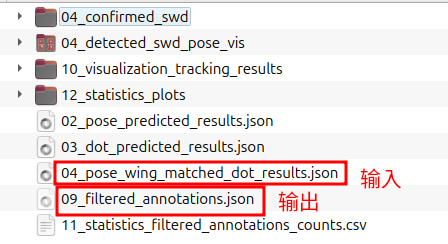

In [103]:
import json
from pathlib import Path
from typing import Dict, Any


def filter_annotations_by_matched_uuid(
    matched_file: Path, annotations_file: Path, output_file: Path
) -> None:
    """
    根据 matched_file 中标记 matched=True 的 uuid，
    从 annotations_file 中筛选对应的标注，并保存到 output_file。

    Args:
        matched_file (str): 匹配结果 JSON 文件路径，例如 '04_pose_wing_matched_dot_results.json'
        annotations_file (str): 原始标注 JSON 文件路径，例如 '01_merged_annotations.json'
        output_file (str): 输出 JSON 文件路径，例如 '09_filtered_annotations.json'
    """

    # 读取数据
    with matched_file.open("r", encoding="utf-8") as f:
        matched_data = json.load(f)

    with annotations_file.open("r", encoding="utf-8") as f:
        annotations_data: Dict[str, Any] = json.load(f)

    # 获取 matched 的 UUID
    matched_uuids = {item["uuid"] for item in matched_data if item.get("matched")}

    # 过滤标注
    filtered_annotations = {
        name: [ann for ann in anns if ann["uuid"] in matched_uuids]
        for name, anns in annotations_data.items()
    }
    # 移除空的类别
    filtered_annotations = {
        name: anns for name, anns in filtered_annotations.items() if anns
    }

    # 保存结果
    output_path = output_file
    with output_path.open("w", encoding="utf-8") as f:
        json.dump(filtered_annotations, f, indent=2, ensure_ascii=False)

    print(f"✅ 过滤完成！结果已保存到 {output_path}")

In [104]:
for chosen_dir in chosen_dirs:
    print(f"选择的目录: {chosen_dir}")
    filter_annotations_by_matched_uuid(
        matched_file= chosen_dir.parent / (chosen_dir.name + "_sliced_merge") / f"pose_and_det_{version}" / "04_pose_wing_matched_dot_results.json",
        annotations_file=chosen_dir.parent / (chosen_dir.name + "_sliced_merge") / "01_merged_annotations.json",
        output_file=chosen_dir.parent / (chosen_dir.name + "_sliced_merge") / f"pose_and_det_{version}" / "09_filtered_annotations.json"
    )

选择的目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
✅ 过滤完成！结果已保存到 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/pose_and_det_v1/09_filtered_annotations.json
